In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math

In [2]:
def print_memory_usage():
    allocated = torch.cuda.memory_allocated()
    cached = torch.cuda.memory_reserved()
    print(f'Allocated Memory: {allocated} bytes')
    print(f'Cached Memory: {cached} bytes')

# Before a forward pass
print_memory_usage()

Allocated Memory: 0 bytes
Cached Memory: 0 bytes


In [2]:
from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import *

In [3]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 50
spinup = 1001
spacing = 1
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

batch_size = 100 # 256 Largest possible batch size that fits on the GPU w.f32

date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{autoencoder_model}/')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.6132266521453857 # -0.6324582099914551
std_data_latent = 5.066834926605225 # 5.280972003936768
std_residual_latent =5.375336170196533# 5.724194526672363
 
#ae-3ds-16f-2l-150e-L1-0wd-0.00001l1
#mean_data_latent = -1.2714290618896484
#std_data_latent = 3.313279628753662

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:


date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'


result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{result_model}/')

import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(result_path / 'best_model.pth')

# Read parameters from JSON file
with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True# if model_name == "generate" else True
    
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model=model_name, img_resolution = 16)

# Load the state_dict of the saved model into the conv_autoencoder
model.load_state_dict(saved_model)

model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [6]:
print_memory_usage()

Allocated Memory: 14237184 bytes
Cached Memory: 14680064 bytes


# Data Loading

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

k = 50

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
#test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print_memory_usage()

Allocated Memory: 14237184 bytes
Cached Memory: 14680064 bytes


# Autoencoder

In [6]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']
# 
# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [12]:
print_memory_usage()

Allocated Memory: 16053248 bytes
Cached Memory: 16777216 bytes


In [21]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

Mean: -6.831114205851918e-06
Standard Deviation: 5.375336170196533
-0.03832172974944115 1.3086596727371216 6.599302768707275


# Diffusion

### Sampling

In [6]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

NameError: name 'model' is not defined

In [7]:
def sample_and_plot_with_truth(net, class_labels = None, truth = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    if class_labels is not None:
        images = torch.cat([truth.unsqueeze(0), images], dim=0)
    
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

for previous, current in train_loader:
    with torch.no_grad():
        current_latent = autoencoder.encoder(current)
        current_latent = (current_latent - mean_data_latent) / std_data_latent

        previous_latent = autoencoder.encoder(previous)
        previous_latent = (previous_latent - mean_data_latent) / std_data_latent

    current_latent = current_latent[0].unsqueeze(0)
    previous_latent = previous_latent[0].unsqueeze(0)
    break
sample_and_plot_with_truth(model, class_labels = previous_latent, truth = current_latent)

NameError: name 'model' is not defined

In [7]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            
            #current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            
            #residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        #residual_latent = residual_latent[0].unsqueeze(0)
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = previous_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)

    
    residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

NameError: name 'model' is not defined

In [8]:
def sample_and_upsample(net, class_labels = None, img_channels=1, num_images=16):
    sampler_fn = edm_sampler
    
    latents = torch.randn([num_images, img_channels, net.img_resolution, net.img_resolution], device=device)
    images, _  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    images = images * std_data_latent + mean_data_latent
    images = autoencoder.decoder(images.to(torch.float32)).cpu().detach().numpy()

    sqrt_num_images = int(np.ceil(math.sqrt(num_images)))

    fig, axes = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(16,16))

    for i in range(images.shape[0]):
        axes[i // sqrt_num_images, i % sqrt_num_images].imshow(images[i,0])
        axes[i // sqrt_num_images, i % sqrt_num_images].axis('off')
        plt.tight_layout()  


    plt.show()
sample_and_upsample(model)

NameError: name 'model' is not defined

In [ ]:
def plot_real_images(net, class_labels = None, img_channels=1, num_images=16):
    
    for previous, current in train_loader:
        images = current[:num_images]
        break
    sqrt_num_images = int(np.ceil(math.sqrt(num_images)))

    fig, axes = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(16,16))

    for i in range(images.shape[0]):
        axes[i // sqrt_num_images, i % sqrt_num_images].imshow(images[i,0])
        axes[i // sqrt_num_images, i % sqrt_num_images].axis('off')
        plt.tight_layout()  


    plt.show()
plot_real_images(model)

### Training

In [7]:
#from prediff.models.cuboid_transformer import CuboidTransformerUNet
#import warnings

ImportError: cannot import name 'CuboidTransformerUNet' from 'earthformer.cuboid_transformer' (c:\Users\svart\Desktop\MEX\QG-Forecasting\earthformer\cuboid_transformer\__init__.py)

In [14]:
forecasting = True

num_epochs = 200

model = GCPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3541473


In [32]:
# Both Generation and Forecasting

import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0

    for previous, current in tqdm(train_loader):
        count += 1
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}, 'warmup_scheduler.get_last_lr())

            current_loss = 0
            count = 0
        
        #warmup_scheduler.step()

            
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in tqdm(val_loader):
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

  8%|▊         | 100/1313 [00:34<08:20,  2.42it/s]

Average Loss: 41.5354


 15%|█▌        | 200/1313 [01:15<07:43,  2.40it/s]

Average Loss: 41.0153


 23%|██▎       | 300/1313 [01:57<07:00,  2.41it/s]

Average Loss: 40.5123


 30%|███       | 400/1313 [02:39<06:23,  2.38it/s]

Average Loss: 40.4158


 38%|███▊      | 500/1313 [03:21<05:38,  2.40it/s]

Average Loss: 41.0705


 46%|████▌     | 600/1313 [04:02<04:54,  2.42it/s]

Average Loss: 40.9431


 53%|█████▎    | 700/1313 [04:44<04:13,  2.42it/s]

Average Loss: 39.9193


 61%|██████    | 800/1313 [05:25<03:32,  2.41it/s]

Average Loss: 40.0784


 69%|██████▊   | 900/1313 [06:10<03:44,  1.84it/s]

Average Loss: 41.6880


 76%|███████▌  | 1000/1313 [07:13<03:16,  1.59it/s]

Average Loss: 40.5585


 80%|████████  | 1052/1313 [07:51<03:29,  1.24it/s]

### Evaluate Forecasts

In [9]:
def autoregressive_forecast(model, previous_latent, sampler_fn=edm_sampler, num_forecasts=1):
    class_labels = previous_latent

    for i in range(num_forecasts):
        latents = torch.randn([previous_latent.size(0), previous_latent.size(1), model.img_resolution, model.img_resolution], device=device)
        predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        class_labels = predicted_latent

    return predicted_latent

C:\Users\svart\AppData\Local\Temp\ipykernel_17708\435000378.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


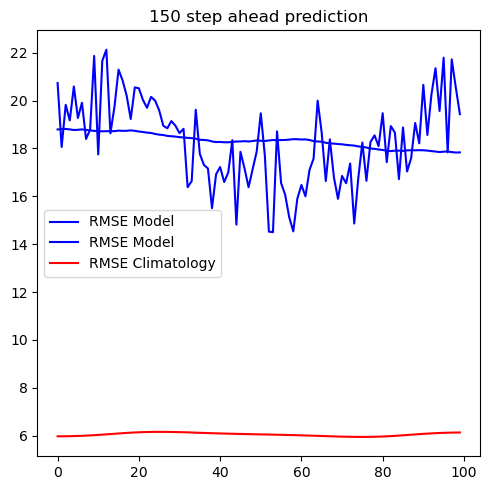

In [31]:
from scipy.ndimage.filters import uniform_filter1d
running_mean = 100

def generate_forecasts(model):
    model.eval()
    sampler_fn = edm_sampler

    num_images = 1000
    num_images -= num_images%batch_size
    rmse_model_list = np.zeros(num_images)
    rmse_clim_list = np.zeros(num_images)

    count=0
    for previous, current in val_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            residual_latent = (current_latent - previous_latent) / std_residual_latent
            
            latents = torch.randn([residual_latent.size(0), residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent

            predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = previous_latent + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current * std_data + mean_data
            previous_unscaled = previous * std_data + mean_data

            climatology = current_unscaled.mean(dim=0)

            rmse_model = ((predicted_unscaled - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()
            rmse_clim = ((climatology - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()

            rmse_model_list[count:count+rmse_model.size] = rmse_model
            rmse_clim_list[count:count+rmse_model.size] = rmse_clim

            count += rmse_model.size
        if count >= num_images:
            break
        
    return rmse_model_list, rmse_clim_list

rmse_model, rmse_clim = generate_forecasts(model)

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='RMSE Model', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='RMSE Climatology', color='r')
plt.ylim(0,11)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

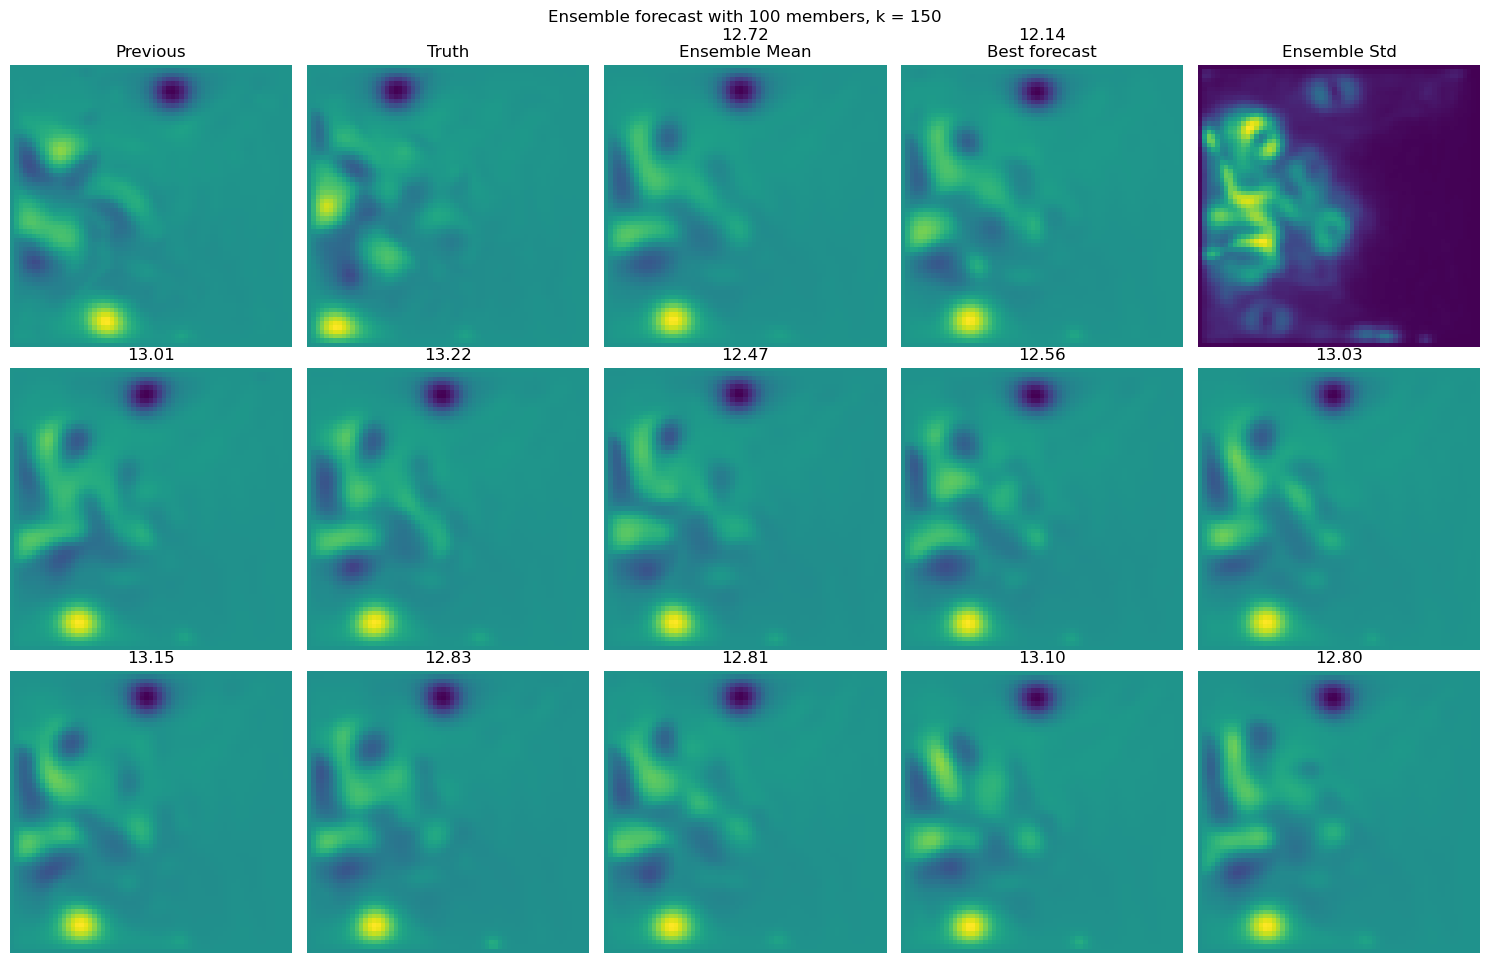

: 

In [37]:
def plot_ensemble(model, selected_loader=val_loader, n_ens=10):
    model.eval()
    sampler_fn = edm_sampler

    for previous, current in selected_loader:

        with torch.no_grad():
            batch_size = current.size(0)

            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            residual_latent = (current_latent - previous_latent) / std_residual_latent
            
            for i in range(batch_size):
                
                class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

                for i in range(1):
                    latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
                    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
                    predicted_latent = class_labels + predicted_residuals * std_residual_latent
                    class_labels = predicted_latent




                predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

                predicted_unscaled = predicted * std_data + mean_data
                current_unscaled = current[i] * std_data + mean_data
                previous_unscaled = previous[i] * std_data + mean_data
                break

        break

    ensemble_mean = predicted_unscaled.mean(dim=0)
    ensemble_rmse = ((ensemble_mean - current_unscaled)**2).mean(dim=(1,2)).sqrt().cpu().detach().numpy()[0]

    ensemble_rmses = ((predicted_unscaled - current_unscaled)**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()
    best_forecast = predicted_unscaled[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    current_unscaled = current_unscaled.cpu().detach().numpy()[0]
    previous_unscaled = previous_unscaled.cpu().detach().numpy()[0]
    best_forecast = best_forecast.cpu().detach().numpy()[0]
    ensemble_mean = ensemble_mean.cpu().detach().numpy()[0]

    ensemble_std = predicted_unscaled.std(dim=0).cpu().detach().numpy()[0]

    plt.set_cmap('viridis')
    no_ens_rows = 2
    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'Ensemble forecast with {n_ens} members, k = {k}')
    axes[0,0].imshow(previous_unscaled)
    axes[0,0].set_title("Previous")
    axes[0,0].axis('off')

    axes[0,1].imshow(current_unscaled)
    axes[0,1].set_title("Truth")
    axes[0,1].axis('off')

    axes[0,2].imshow(ensemble_mean)
    axes[0,2].set_title(f"{ensemble_rmse:.2f}\nEnsemble Mean")
    axes[0,2].axis('off')

    axes[0,3].imshow(best_forecast)
    axes[0,3].set_title(f"{best_rmse:.2f}\nBest forecast")
    axes[0,3].axis('off')

    axes[0,4].imshow(ensemble_std)
    axes[0,4].set_title("Ensemble Std")
    axes[0,4].axis('off')


    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            axes[1+i,j].imshow(predicted_unscaled[count].cpu().detach().numpy()[0])
            axes[1+i,j].set_title(f"{ensemble_rmses[count]:.2f}")
            axes[1+i,j].axis('off')
            count+=1
        
            plt.tight_layout()
    
    return ensemble_rmse, ensemble_rmses, predicted_unscaled.cpu().detach().numpy(), current_unscaled
    plt.show()

ensemble_rmse, ensemble_rmses, forecasts, truth  = plot_ensemble(model, n_ens=100, selected_loader=val_loader)
plt.show()

forecasts = forecasts.reshape((100, 65,65))

<Figure size 640x480 with 0 Axes>

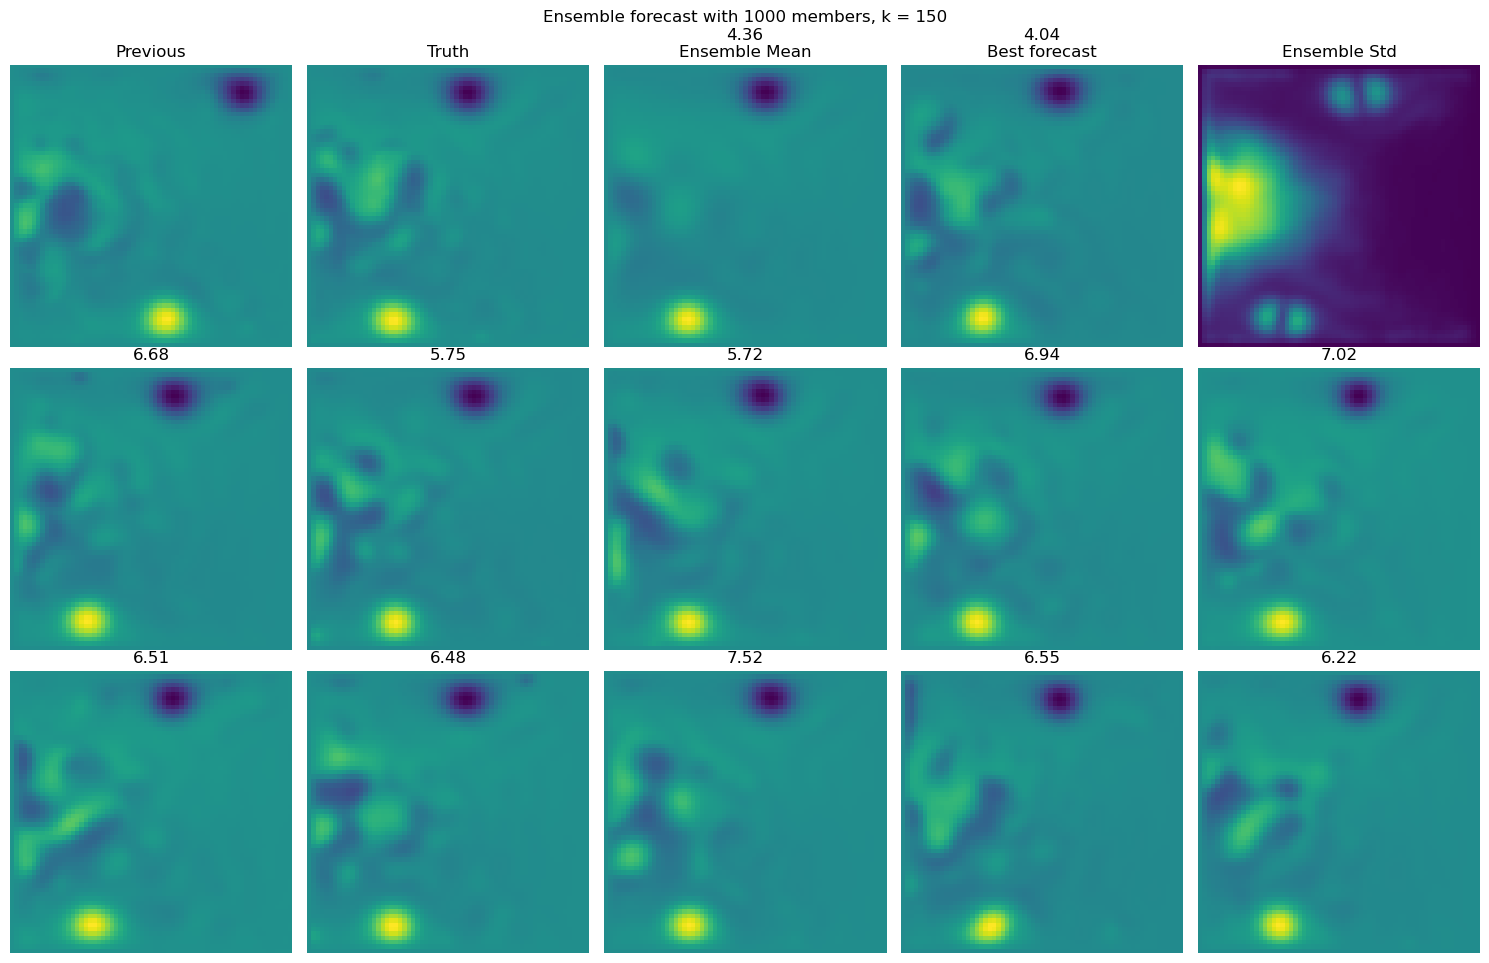

In [284]:
model.eval()
sampler_fn = edm_sampler

n_ens=1000
selected_loader=shuffled_val_loader

for previous, current in selected_loader:

    with torch.no_grad():
        batch_size = current.size(0)

        current_latent = autoencoder.encoder(current)
        previous_latent = autoencoder.encoder(previous)
        residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        for i in range(batch_size):
            latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

            predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = class_labels + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current[i] * std_data + mean_data
            previous_unscaled = previous[i] * std_data + mean_data
            break

    break

ensemble_mean = predicted_unscaled.mean(dim=0)
ensemble_rmse = ((ensemble_mean - current_unscaled)**2).mean(dim=(1,2)).sqrt().cpu().detach().numpy()[0]

ensemble_rmses = ((predicted_unscaled - current_unscaled)**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()
best_forecast = predicted_unscaled[np.argmin(ensemble_rmses)]
best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

current_unscaled = current_unscaled.cpu().detach().numpy()[0]
previous_unscaled = previous_unscaled.cpu().detach().numpy()[0]
best_forecast = best_forecast.cpu().detach().numpy()[0]
ensemble_mean = ensemble_mean.cpu().detach().numpy()[0]

ensemble_std = predicted_unscaled.std(dim=0).cpu().detach().numpy()[0]

plt.set_cmap('viridis')
no_ens_rows = 2
fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
fig.suptitle(f'Ensemble forecast with {n_ens} members, k = {k}')
axes[0,0].imshow(previous_unscaled)
axes[0,0].set_title("Previous")
axes[0,0].axis('off')

axes[0,1].imshow(current_unscaled)
axes[0,1].set_title("Truth")
axes[0,1].axis('off')

axes[0,2].imshow(ensemble_mean)
axes[0,2].set_title(f"{ensemble_rmse:.2f}\nEnsemble Mean")
axes[0,2].axis('off')

axes[0,3].imshow(best_forecast)
axes[0,3].set_title(f"{best_rmse:.2f}\nBest forecast")
axes[0,3].axis('off')

axes[0,4].imshow(ensemble_std)
axes[0,4].set_title("Ensemble Std")
axes[0,4].axis('off')


count = 0
for i in range(no_ens_rows):
    for j in range(5):
        axes[1+i,j].imshow(predicted_unscaled[count].cpu().detach().numpy()[0])
        axes[1+i,j].set_title(f"{ensemble_rmses[count]:.2f}")
        axes[1+i,j].axis('off')
        count+=1
    
        plt.tight_layout()

forecasts = predicted_unscaled.cpu().detach().numpy().reshape((n_ens, 65,65))
truth = current_unscaled
plt.show()

In [137]:

ensemble_mean = autoencoder.encoder(torch.tensor(np.mean(forecasts, axis=0)).to(device).unsqueeze(0).unsqueeze(0))

In [282]:
current_unscaled

array([[-4.56321659e-03, -4.07431498e-02, -4.72937226e-02, ...,
        -2.40011830e-02, -1.98796671e-02, -3.91776534e-03],
       [-4.87148389e-02, -4.21669394e-01, -4.04484808e-01, ...,
        -1.29187226e-01, -1.35302588e-01, -2.69686878e-02],
       [-4.07897308e-02, -4.94155884e-01, -4.34823513e-01, ...,
         4.24765311e-02,  1.21074654e-02, -1.01374295e-02],
       ...,
       [-3.58691290e-02,  1.15364660e-02, -9.55178142e-02, ...,
        -3.27181928e-02,  9.21357423e-03,  1.29573978e-04],
       [-3.82082015e-02, -1.88336208e-01, -1.93208262e-01, ...,
         6.60813786e-03,  1.62095074e-02,  3.96262389e-04],
       [-6.83906255e-03, -5.92321269e-02, -1.45332515e-02, ...,
         1.82103564e-03,  1.92744867e-03,  5.28935343e-05]], dtype=float32)

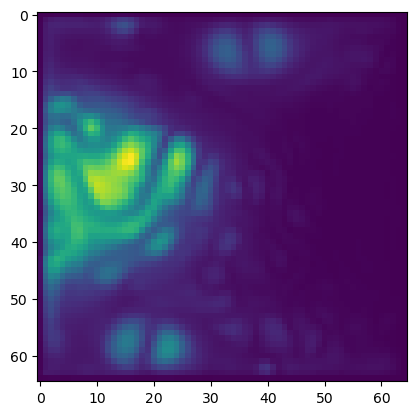

In [292]:
plt.imshow(np.sqrt(((forecasts - truth)**2).mean(axis=(0))))


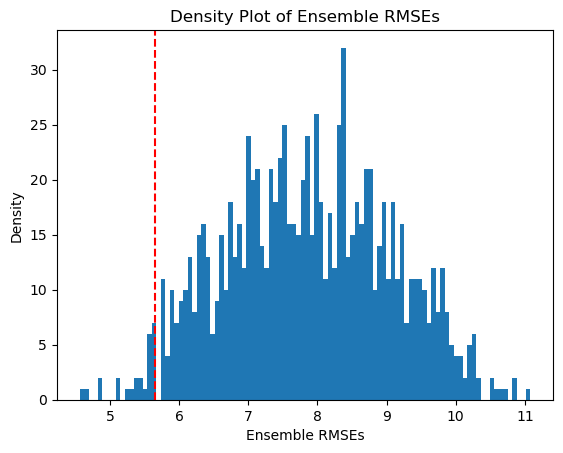

In [275]:
import matplotlib.pyplot as plt

plt.hist(ensemble_rmses, bins=100)
plt.axvline(ensemble_rmse, color='red', linestyle='--')

plt.xlabel('Ensemble RMSEs')
plt.ylabel('Density')
plt.title('Density Plot of Ensemble RMSEs')
plt.show()


In [293]:
def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps, class_labels=None):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t, class_labels) * eps, axis=(1,2,3))
      #print(x.shape, eps.shape, fn_eps.shape)
      grad_fn_eps = torch.zeros_like(eps)

      for i in range(eps.size(0)):
          dl = torch.autograd.grad(fn_eps[i], x, create_graph=True, allow_unused=True)[0]
          grad_fn_eps[i] = dl

    x.requires_grad_(False)
    res = torch.sum(grad_fn_eps * eps, dim=(1,2,3)).mean(dim=0)
    return res

  return div_fn


def div_fn(model, x, t, noise, class_labels=None):
    return get_div_fn(lambda xx, tt, class_labels: drift_fn(model, xx, tt, class_labels))(x, t, noise, class_labels)


In [310]:
def edm_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents * t_steps[0]
    xs = [x_next]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels)#.to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels)#.to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        
        xs.append(x_next)

    return x_next, torch.stack(xs) #xs[::-1])

In [296]:
def likelihood_sampler(
    net, latents, samples, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
    eps_multiplier=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = samples[0]
    
    # Need to make eps_shape one more dimension
    #eps_shape = (eps_multiplier,) + x_next.shape
    
    eps_shape = x_next.shape
    eps_shape = (eps_shape[0] * eps_multiplier,) + eps_shape[1:]  # Double the number of channels
    epsilon = torch.randn(eps_shape).to(device)
    #print(epsilon.shape)
    div_next = div_fn(net, x_next, t_steps[0], epsilon, class_labels)

    N = np.prod(latents.shape[1:])
    prior_logp = -N / 2. * np.log(2 * np.pi * sigma_max ** 2) - torch.sum(latents ** 2, dim=(1, 2, 3)) / (2 * sigma_max ** 2)
    prior_logp = prior_logp[0]
    #prior_logp = torch.tensor(0.0).to(device)
    post_logp = prior_logp# torch.tensor(0.0).to(device) # torch.zeros_like(prior_logp) #prior_logp

    #logps = [prior_logp]
    
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_next = samples[i + 1]

        # Likelihood
        div_cur = div_next
        
        if i < num_steps - 1:
            epsilon = torch.randn(eps_shape).to(device)
            div_next = div_fn(net, x_next, t_next, epsilon, class_labels)
            delta_logp = (div_cur + div_next) * (t_next - t_cur) / 2
            
            post_logp += delta_logp
            #logps.append(delta_logp)

    return post_logp #, torch.stack(logps)


In [311]:
torch.manual_seed(0)
model.eval()
sampler_fn = edm_sampler
#likelihood_sampler

n_ens = 10
for previous, current in shuffled_val_loader:
    with torch.no_grad():
        batch_size = current.size(0)

        current_latent = autoencoder.encoder(current)
        previous_latent = autoencoder.encoder(previous)
        residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        for i in range(batch_size):
            latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

            predicted_residuals, predicted_residuals_list = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, 
                                                                    num_steps=100, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = class_labels + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current[i] * std_data + mean_data
            previous_unscaled = previous[i] * std_data + mean_data

            ensemble_rmses = ((predicted_unscaled - current_unscaled)**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()
            break
    break

    #current_unscaled = current_unscaled.cpu().detach().numpy()[0]
    #previous_unscaled = previous_unscaled.cpu().detach().numpy()[0]

In [312]:
res_list = {}
eps_multiplier = 10

for j in range(n_ens):
    print("Ensemble ", j)
    res_tmp = []
    for i in range(1):
        logps = likelihood_sampler(model, latents[j].unsqueeze(0), predicted_residuals_list[:,j].unsqueeze(1), class_labels[j].unsqueeze(0), eps_multiplier=eps_multiplier,
                                      sigma_max=80, sigma_min=0.03, rho=7, num_steps=100, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        res_tmp.append(logps.item())
        print(logps.item())
    res_list[np.round(ensemble_rmses[j],3)] = res_tmp

sorted_keys = sorted(res_list.keys())

# Sort the data based on the sorted keys
sorted_data = [res_list[key] for key in sorted_keys]

plt.boxplot(sorted_data, labels=sorted_keys)
#plt.plot(logps_list)

#print("Std", np.array(res_list).std())

Ensemble  0


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.99 GiB is allocated by PyTorch, and 474.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
def drift_fn(model, x, t, class_labels=None):
    """The drift function of the reverse-time SDE."""
    sigma = t
    D_x = model(x, sigma, class_labels)
    S_x = (D_x - x)/(sigma**2)
    return S_x


def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps, class_labels=None):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t, class_labels) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn


def div_fn(model, x, t, noise, class_labels=None):
    return get_div_fn(lambda xx, tt, class_labels: drift_fn(model, xx, tt, class_labels))(x, t, noise, class_labels)


def likelihood_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]

    epsilon = torch.randn_like(x_next)
    div_next = div_fn(net, x_next, t_steps[0], epsilon, class_labels)

    N = np.prod(latents.shape[1:])
    prior_logp = -N / 2. * np.log(2 * np.pi * sigma_max ** 2) - torch.sum(latents ** 2, dim=(1, 2, 3)) / (2 * sigma_max ** 2)

    post_logp = prior_logp

    xs = [x_next]
    logps = [post_logp]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        
        xs.append(x_next)

        # Likelihood
        div_cur = div_next
        
        if i < num_steps - 1:
          div_next = div_fn(net, x_next, t_next, epsilon, class_labels)
          post_logp += (div_cur + div_next) * (t_next - t_cur) / 2
        else:
           post_logp += div_cur * (t_next - t_cur) / 2
        
        logps.append(post_logp)

    return x_next, torch.stack(xs[::-1]), post_logp, torch.stack(logps[::-1])


## Evaluation Pipeline

 What to do next
 \begin{itemize}
     \item Try other architectures
     \item Evaluation Pipeline
     \begin{itemize}
         \item CRPS
         \begin{itemize}
             \item Empirical and in limit
         \end{itemize}
         \item Brier Score
         \item Ensemble Mean RMSE
         \item Spread/Skill Ratio
         \item Rank Histogram
         \item Power Spectrum/Frequency domain
         \item FID?
         \begin{itemize}
             \item Create something similar from large dataset
         \end{itemize}
     \end{itemize}
     \item Compare variance of model with instability in NWP
     \begin{itemize}
         \item Simple measure such as trace of coovariance matrix
     \end{itemize}
 \end{itemize}


### Pipe

In [7]:
def generate_forecast(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

    predicted_unscaled = predicted * std_data + mean_data

    return predicted_unscaled

In [8]:
def generate_forecasts(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    for previous, current in selected_loader:
        with torch.no_grad():
            previous = previous[0]
            current_dp = current[0] * std_data + mean_data
            forecast = generate_forecast(model, previous, n_ens, sampler_fn)
            #forecast = autoencoder(current[0].unsqueeze(0))[0] * std_data + mean_data
            return forecast, current_dp

In [9]:
def calculate_skill_and_spread_score(forecast, truth):
    ens_mean = forecast.mean(dim=0)
    skill = ((ens_mean - truth)**2).mean().sqrt()
    
    N = forecast.size(0)
    spread = (((ens_mean - forecast)**2).sum(dim=0)/(N - 1)).mean().sqrt()

    ratio = np.sqrt((N+1)/N) * spread / skill
    return skill.item(), spread.item(), ratio.item()

In [10]:
def calculate_CRPS(forecast, truth):
    a = (forecast - truth).norm(dim=0, p=1)
    b = (forecast.unsqueeze(1) - forecast.unsqueeze(0)).abs().mean(dim=(0,1)) * 0.5
    return (a - b).mean().item()

In [11]:
def calculate_brier_score(forecast, truth, threshold=10):
    px = (forecast > threshold).to(torch.float32).mean(dim=0)
    py = (truth > threshold).to(torch.float32)
    
    brier = ((px - py)**2).mean()
    return brier.item()

In [12]:
forecast, truth = generate_forecasts(model, n_ens=100, selected_loader=val_loader, sampler_fn=edm_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill:.2f}, Spread: {spread:.2f}, Ratio: {ratio:.3f}, CRPS: {crps:.0f}, Brier: {brier:.4f}")

Skill: 2.30, Spread: 2.19, Ratio: 0.955, CRPS: 157, Brier: 0.0068


In [13]:
def evaluation_pipeline(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {'skill': [], 'spread': [], 'ratio': [], 'crps': [], 'brier': []}
    for previous, current in selected_loader:
        for i in range(batch_size):
            with torch.no_grad():
                previous_datapoint = previous[i]
                current_datapoint = current[i] * std_data + mean_data
                forecast = generate_forecast(model, previous_datapoint, n_ens, sampler_fn)
                
                skill, spread, ratio = calculate_skill_and_spread_score(forecast, current_datapoint)
                crps = calculate_CRPS(forecast, current_datapoint)
                brier = calculate_brier_score(forecast, current_datapoint, 20)
                
                results['skill'].append(skill)
                results['spread'].append(spread)
                results['ratio'].append(ratio)
                results['crps'].append(crps)
                results['brier'].append(brier)

    return results

res = evaluation_pipeline(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler)

KeyboardInterrupt: 

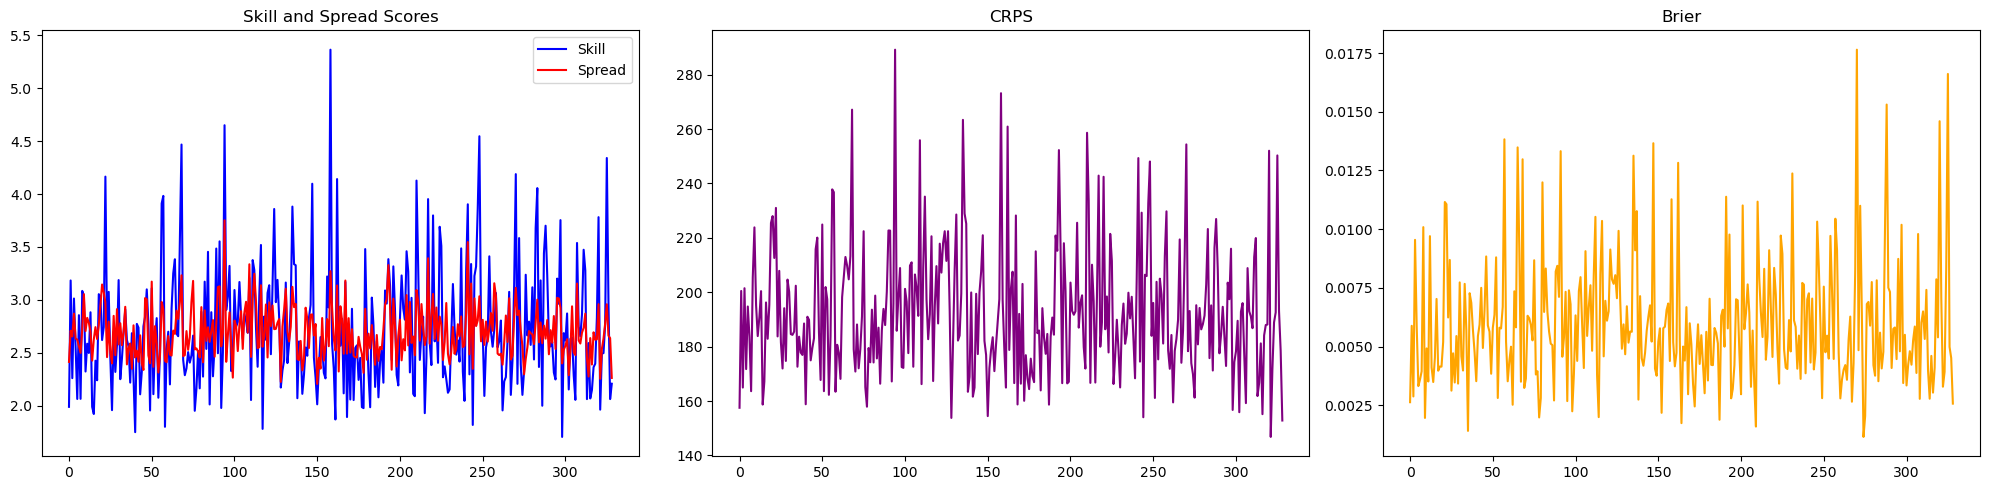

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

#axes[2].plot(res['ratio'], label='Ratio', color='green')
#axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

In [39]:
torch.cov(forecast.view(forecast.size(0), -1)).trace()

NameError: name 'forecast' is not defined

### Variance/ RMSE

In [14]:
def generate_forecast(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

    predicted_unscaled = predicted * std_data + mean_data

    return predicted_unscaled

In [15]:
from utils import NWPDataset

In [16]:
kmax = 50
iterations = 2101000
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{kmax}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{kmax}.npy')


nwp_dataset = NWPDataset(nwp_data_path, n_val, device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)


In [20]:
import tqdm

def validation_pipeline(model, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    count = 0
    results = {'skill': [], 'spread': [], 'ratio': [], 'crps': [], 'brier': [], 'nwp': [], 'covtrace': []}

    for data, nwp in zip(val_loader, nwp_loader):

        previous, current = data
        
        for i in range(batch_size):
            print(count)
            count+=1
            with torch.no_grad():
                previous_datapoint = previous[i]
                current_datapoint = current[i] * std_data + mean_data
                forecast = generate_forecast(model, previous_datapoint, n_ens, sampler_fn)
                
                skill, spread, ratio = calculate_skill_and_spread_score(forecast, current_datapoint)
                crps = calculate_CRPS(forecast, current_datapoint)
                brier = calculate_brier_score(forecast, current_datapoint, 20)
                covtrace = torch.cov(forecast.view(forecast.size(0), -1)).trace().item()

                nwp_datapoint = nwp[i]
                rmse_nwp = ((nwp_datapoint - current_datapoint)**2).mean().sqrt().item()

                results['nwp'].append(rmse_nwp)
                results['covtrace'].append(covtrace)

                results['skill'].append(skill)
                results['spread'].append(spread)
                results['ratio'].append(ratio)
                results['crps'].append(crps)
                results['brier'].append(brier)

            if count >= 1000:
                return results

    return results

res = validation_pipeline(model, n_ens=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

In [14]:
print_memory_usage()

Allocated Memory: 16053248 bytes
Cached Memory: 16777216 bytes


In [166]:
rmse_nwp = []
rmse_model = []
var_model = []
skill_model = []
spread_model = []
crps_model = []
brier_model = []

In [167]:
# Zip ignores longer loader

count = 0
max_count = 1000
with torch.no_grad():
    for nwp, data in zip(nwp_loader, val_loader):
        
        if count > max_count:
            break
        previous, current = data
        current = current * std_data + mean_data

        for i in range(batch_size):
            print(count)
            previous_datapoint = previous[i]
            current_datapoint = current[i]
            nwp_datapoint = nwp[i]
            forecast = generate_forecast(model, previous_datapoint, n_ens=100, sampler_fn=edm_sampler)
            
            rmse_model.append(((forecast - current_datapoint)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy())
            rmse_nwp.append(((nwp_datapoint - current_datapoint)**2).mean().sqrt().cpu().detach().item())
            var_model.append(torch.cov(forecast.view(forecast.size(0), -1)).trace().item())

            truth = current_datapoint
            skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
            skill_model.append(skill)
            spread_model.append(spread)
            crps = calculate_CRPS(forecast, truth)
            crps_model.append(crps)
            brier = calculate_brier_score(forecast, truth, 20)
            brier_model.append(brier)
        
            count +=1 
            if count > max_count:
                break

rmse_model = np.array(rmse_model)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [259]:
# Zip ignores longer loader

count = 0
max_count = 235
with torch.no_grad():
    for nwp, data in zip(nwp_loader, val_loader):
        
        if count >= max_count:
            break
        previous, current = data
        current = current * std_data + mean_data

        for i in range(batch_size):
            print(count)
            previous_datapoint = previous[i]
            current_datapoint = current[i]
            nwp_datapoint = nwp[i]
            
        
            count +=1 
            if count == max_count:
                forecast = generate_forecast(model, previous_datapoint, n_ens=100, sampler_fn=edm_sampler)
                truth = current_datapoint
                break

    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


tensor(8.2518, device='cuda:0')
11.79115104675293
10.468219757080078


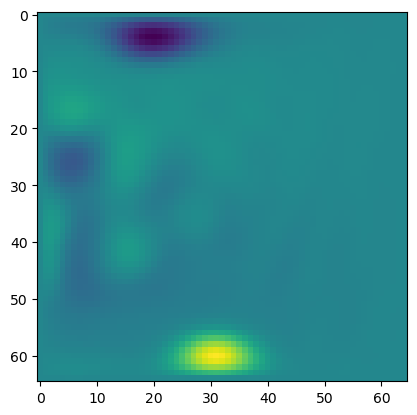

In [263]:
plt.imshow(truth.view(65,65).cpu().detach().numpy())
plt.imshow(forecast.mean(dim=0).view(65,65).cpu().detach().numpy())
#plt.imshow(nwp_datapoint.view(65,65).cpu().detach().numpy())
#plt.imshow(forecast[10].view(65,65).cpu().detach().numpy())

print(((truth - forecast.mean(dim=0))**2).mean().sqrt())
print(((truth - nwp_datapoint)**2).mean().sqrt().item())
print(((truth - forecast[10])**2).mean().sqrt().item())

In [168]:
rmse_model = np.array(rmse_model)


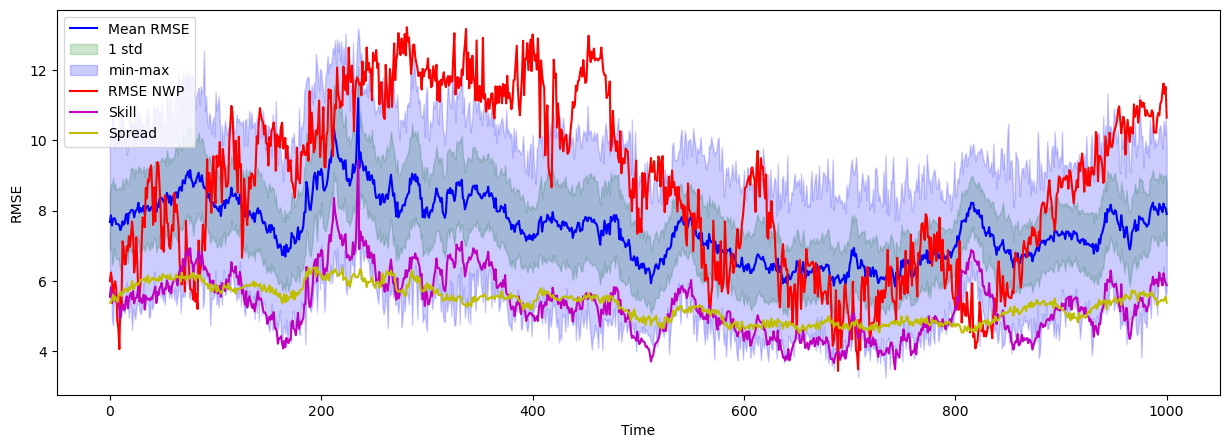

In [264]:
plt.figure(figsize=(15,5))

# Calculate the mean and standard deviation of rmse_model
mean_rmse = np.mean(rmse_model, axis=1)
std_rmse = np.std(rmse_model, axis=1)
min_rmse = np.min(rmse_model, axis=1)
max_rmse = np.max(rmse_model, axis=1)

# Plot the mean line
plt.plot(mean_rmse, label='Mean RMSE', color='blue')

# Plot the standard deviation band
plt.fill_between(range(len(mean_rmse)), mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2, color='green', label="1 std")
plt.fill_between(range(len(mean_rmse)), min_rmse, max_rmse, alpha=0.2, color='blue', label="min-max")
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('RMSE')

# Show the plot

#plt.plot(rmse_model, label='RMSE Model', linewidth=0.05)
plt.plot(rmse_nwp, label='RMSE NWP', color='r')
#plt.plot(var_model, label='Var Model', color='g')
plt.plot(skill_model, label='Skill', color='m')
plt.plot(spread_model, label='Spread', color='y')
#plt.plot(crps_model, label='CRPS Model', color='c')
#plt.plot(brier_model, label='Brier Model', color='k')
plt.legend()
plt.show()

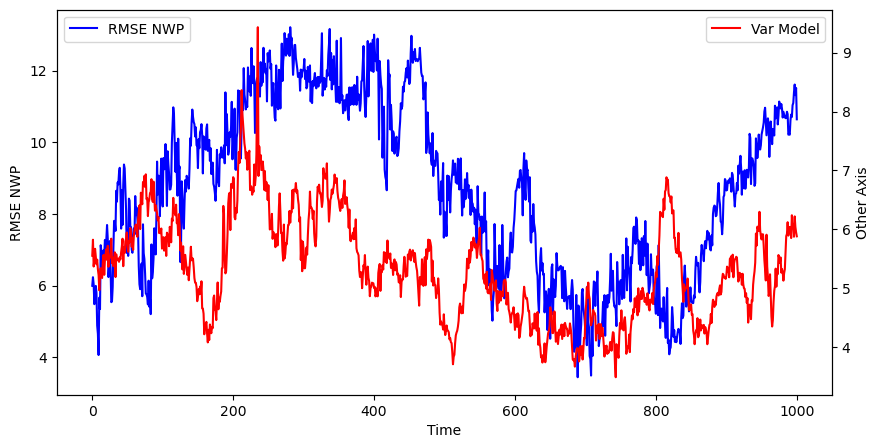

In [174]:
#plt.plot(var_model)
# Plot the rmse_nwp on a separate axis
x = np.arange(0, len(rmse_nwp))
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(x, rmse_nwp, color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')
ax2.set_ylabel('Other Axis')
ax2.plot(x, sk_model, color='red', label='Var Model')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


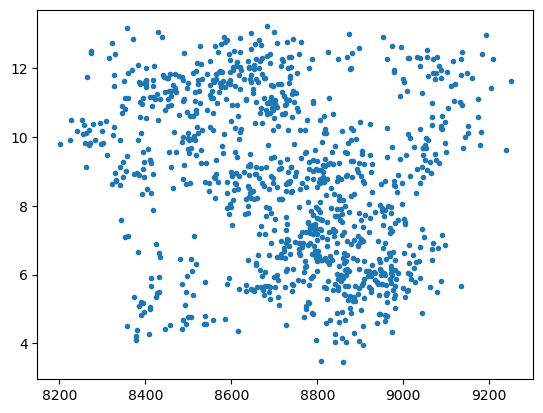

In [171]:
plt.plot(var_model, rmse_nwp, marker='.', linestyle='')
#plt.plot(var_model, rmse_model.mean(axis=1), marker='o', linestyle='')

In [197]:
forecasts.shape

(1000, 65, 65)

### Likelihood

In [6]:
model_name = "ncsnpp-f32-k50"
result_path = "ncsnpp-f32-k50/.pth"

saved_model = torch.load(result_path/)

model = GCPrecond(filters=32, img_channels=2, img_resolution = 16, model='ddpmpp')

model.load_state_dict(saved_model)

model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [7]:
from scipy import integrate

def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps, class_labels=None):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t, class_labels) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn

def to_flattened_numpy(x):
  """Flatten a torch tensor `x` and convert it to numpy."""
  return x.detach().cpu().numpy().reshape((-1,))


def from_flattened_numpy(x, shape):
  """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
  return torch.from_numpy(x.reshape(shape))

def get_likelihood_fn(MODEL, hutchinson_type='Rademacher',
                      rtol=1e-5, atol=1e-5, method='RK45', eps=1e-5):
  """Create a function to compute the unbiased log-likelihood estimate of a given data point.

  Args:
    sde: A `sde_lib.SDE` object that represents the forward SDE.
    inverse_scaler: The inverse data normalizer.
    hutchinson_type: "Rademacher" or "Gaussian". The type of noise for Hutchinson-Skilling trace estimator.
    rtol: A `float` number. The relative tolerance level of the black-box ODE solver.
    atol: A `float` number. The absolute tolerance level of the black-box ODE solver.
    method: A `str`. The algorithm for the black-box ODE solver.
      See documentation for `scipy.integrate.solve_ivp`.
    eps: A `float` number. The probability flow ODE is integrated to `eps` for numerical stability.

  Returns:
    A function that a batch of data points and returns the log-likelihoods in bits/dim,
      the latent code, and the number of function evaluations cost by computation.
  """

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    return -N / 2. * np.log(2 * np.pi * self.sigma_max ** 2) - torch.sum(z ** 2, dim=(1, 2, 3)) / (2 * self.sigma_max ** 2)


  def drift_fn(model, x, t, class_labels=None):
    """The drift function of the reverse-time SDE."""
    sigma = t
    D_x = model(x, sigma, class_labels)
    S_x = (D_x - x)/(sigma**2)
    return S_x
    
    score_fn = mutils.get_score_fn(sde, model, train=False, continuous=True)
    # Probability flow ODE is a special case of Reverse SDE
    rsde = sde.reverse(score_fn, probability_flow=True)
    return rsde.sde(x, t)[0]

  def div_fn(model, x, t, noise, class_labels=None):
    return get_div_fn(lambda xx, tt, class_labels: drift_fn(model, xx, tt, class_labels))(x, t, noise, class_labels)

  def likelihood_fn(model, data, class_labels=None):
    """Compute an unbiased estimate to the log-likelihood in bits/dim.

    Args:
      model: A score model.
      data: A PyTorch tensor.

    Returns:
      bpd: A PyTorch tensor of shape [batch size]. The log-likelihoods on `data` in bits/dim.
      z: A PyTorch tensor of the same shape as `data`. The latent representation of `data` under the
        probability flow ODE.
      nfe: An integer. The number of function evaluations used for running the black-box ODE solver.
    """
    with torch.no_grad():
      shape = data.shape
      if hutchinson_type == 'Gaussian':
        epsilon = torch.randn_like(data)
      elif hutchinson_type == 'Rademacher':
        epsilon = torch.randint_like(data, low=0, high=2).float() * 2 - 1.
      else:
        raise NotImplementedError(f"Hutchinson type {hutchinson_type} unknown.")

      def ode_func(t, x):
        sample = from_flattened_numpy(x[:-shape[0]], shape).to(data.device).type(torch.float32)
        vec_t = torch.ones(sample.shape[0], device=sample.device) * t
        drift = to_flattened_numpy(drift_fn(model, sample, vec_t, class_labels))
        logp_grad = to_flattened_numpy(div_fn(model, sample, vec_t, epsilon, class_labels))
        return np.concatenate([drift, logp_grad], axis=0)

      init = np.concatenate([to_flattened_numpy(data), np.zeros((shape[0],))], axis=0)
      solution = integrate.solve_ivp(ode_func, (eps, MODEL.sigma_max), init, rtol=rtol, atol=atol, method=method)
      #nfe = solution.nfev
      zp = solution.y[:, -1]
      z = from_flattened_numpy(zp[:-shape[0]], shape).to(data.device).type(torch.float32)
      delta_logp = from_flattened_numpy(zp[-shape[0]:], (shape[0],)).to(data.device).type(torch.float32)
            
      prior_logp = prior_logp(z)

      post_logp = prior_logp + delta_logp
      #bpd = -(prior_logp + delta_logp) / np.log(2)
      #N = np.prod(shape[1:])
      #bpd = bpd / N
      # A hack to convert log-likelihoods to bits/dim
      #offset = 7. - inverse_scaler(-1.)
      #bpd = bpd + offset
      return zp, post_logp #bpd, z, nfe

  return likelihood_fn

In [8]:
for previous, current in val_loader:
    prev = autoencoder.encoder(previous)[0:10]#.unsqueeze(0)
    curr = autoencoder.encoder(current)[0:10]#.unsqueeze(0)
    break


In [9]:
likelihood_fn = get_likelihood_fn(model, atol=10, rtol=0.1)
res = likelihood_fn(model, curr, prev)
A = res[-1,:]

RuntimeError: The size of tensor a (16) must match the size of tensor b (10) at non-singleton dimension 3

In [12]:
def generate_forecast(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
    predicted_unscaled = predicted * std_data + mean_data

    also_sample, logp = likelihood_fn(model, latents, previous_latent)
    also_sample = class_labels + also_sample * std_residual_latent
    also_sample = autoencoder.decoder(also_sample.to(torch.float32))
    also_sample = also_sample * std_data + mean_data

    return predicted_unscaled, also_sample, logp

In [13]:
res = generate_forecast(model, previous[0], n_ens=1)

KeyboardInterrupt: 

tensor([-15436.7246], device='cuda:0')


Text(0.5, 1.0, 'Current')

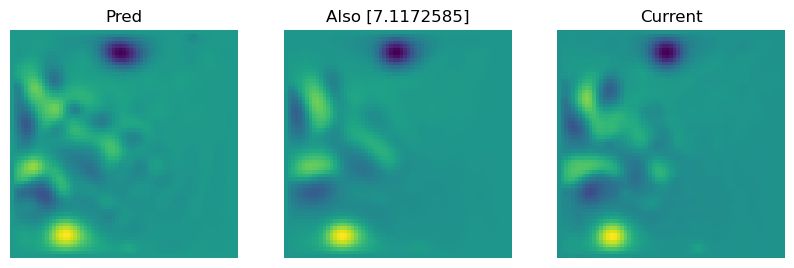

In [137]:
pred, also_pred, logp = res
print(logp)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pred.detach().cpu().numpy()[0,0])
axes[0].axis('off')
axes[0].set_title('Pred')

axes[1].imshow(also_pred.detach().cpu().numpy()[0,0])
axes[1].axis('off')
axes[1].set_title(f'Also {((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()}')


axes[2].imshow(current.detach().cpu().numpy()[0,0])
axes[2].axis('off')
axes[2].set_title('Current')


In [136]:
((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()

array([7.1172585], dtype=float32)

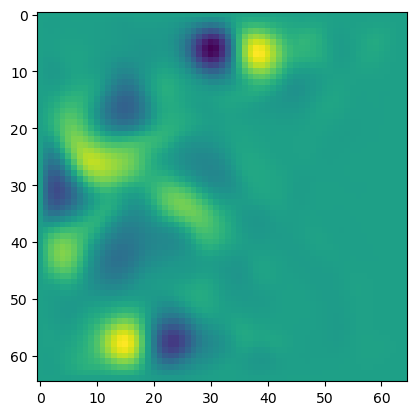

In [117]:
plt.imshow(autoencoder.decoder(autoencoder.encoder(previous)[0].unsqueeze(0) + also_pred * std_residual_latent).detach().cpu().numpy()[0,0])

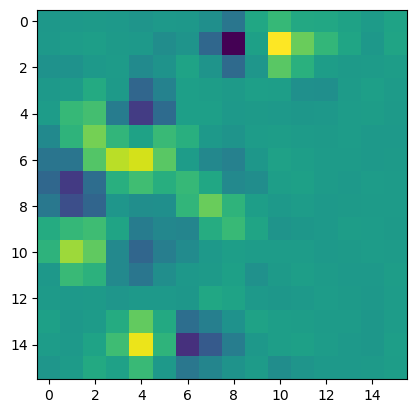

### Misc

In [113]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
real_distances = []
fake_distances = []

for data, _ in val_loader:
    data = data[0]
    real_distance = np.linalg.norm(random_image - data.cpu().detach().numpy())
    fake_distance = np.linalg.norm(images[0, 0].detach().numpy() - data.cpu().detach().numpy())

    real_distances.append(real_distance)
    fake_distances.append(fake_distance)


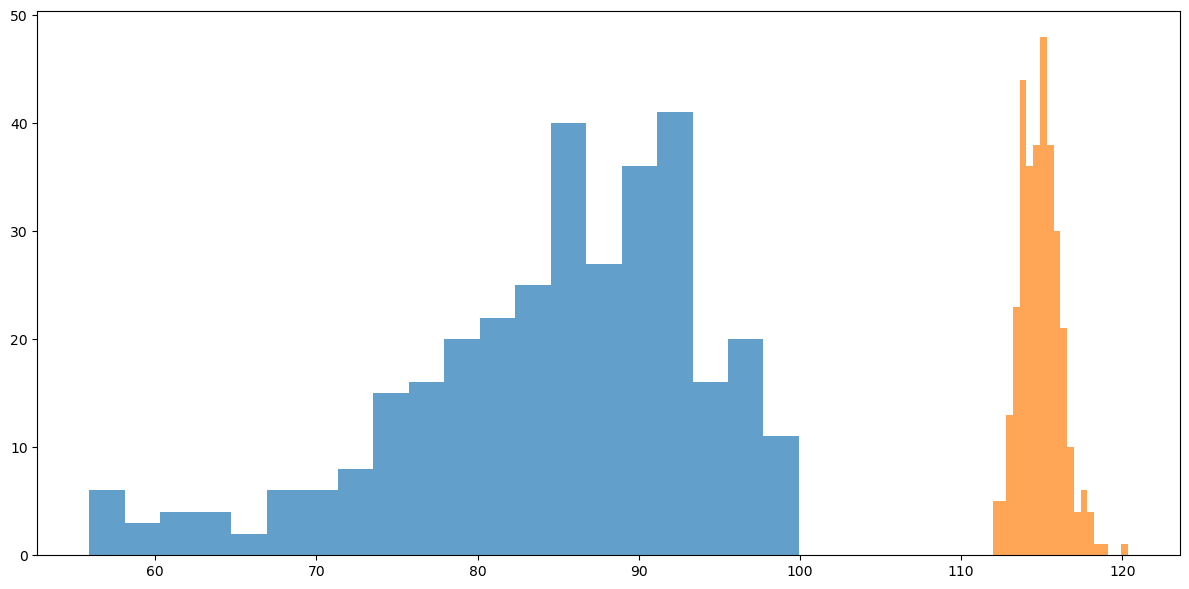

In [114]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

plt.hist(real_distances, bins=20, alpha=0.7, label='Real Images')
plt.hist(fake_distances, bins=20, alpha=0.7, label='Fake Images')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

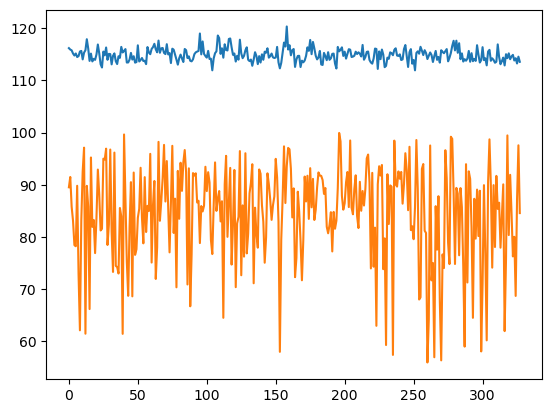

In [115]:
plt.plot(fake_distances)
plt.plot(real_distances)